# Simulate a GPR Survey

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

def gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR):
    global c 
    c = 3e8
    v = c / np.sqrt(eps_r)
    
    xlen, tlen = region_shape # Physical extent in two dimension, in units of [m] and [t]

    # Antenna positions along surface
    x_positions = np.arange(0, xlen, dx)
    nx = len(x_positions) # The number of scans taken

    # Time axis, max penetration depth in ns
    t_samples = np.arange(0, tlen, dt)
    nt = len(t_samples) # The number of scans taken
        
    data = np.zeros((nx, nt))
    for j, x_ant in enumerate(x_positions):
        for (xr, zr) in reflectors:
            (xr, zr_m) = (xr, zr*v) # zr in [s], conv. to [m] to get twt
            
            # calculate the twt from the xr to x_ant
            twt = 2 * (np.sqrt((xr - x_ant) ** 2 + zr_m ** 2)/v) # Must convert reflector position to vel est. position [units of s]
            it = int(np.round(twt / dt)) # Convert travel time to nearest sample index
            
            # # Insert a simple spike (or Gaussian wavelet)
            if 0 <= it < nt:
                if wavetype == "spike":
                    data[j, it] = 1
                elif wavetype == "gaussian":
                    wavelet = np.exp(-(((t_samples - twt)) ** 2) * (rf**2))
                    data[j, :] += wavelet
                
                if SNR != math.inf:
                    # Gaussian noise with mean 0 and variance 1
                    noise = np.random.randn(nt)
                    noise = noise * np.std(data[j, :])/np.sqrt(SNR)
                    data[j,:]+=noise
            
    return data.T, x_positions, t_samples


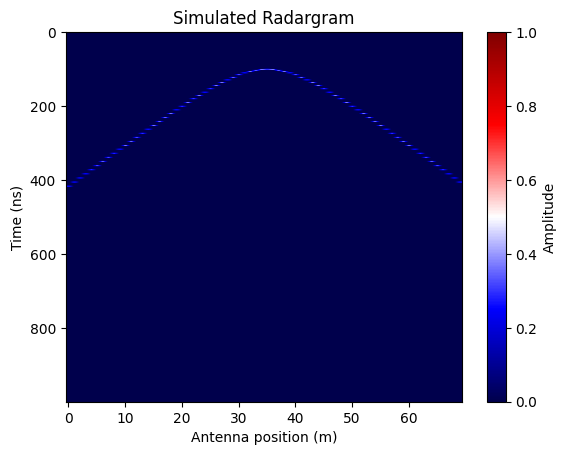

In [3]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
SNR = math.inf
wavetype = 'spike'

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel("Antenna position (m)")
plt.ylabel("Time (ns)")
plt.title("Simulated Radargram")
plt.colorbar(label="Amplitude")
plt.show()

# Helpful visual to show the wave fronts along which all possible refelctor locations lie
## only valid for non-noisy simulation

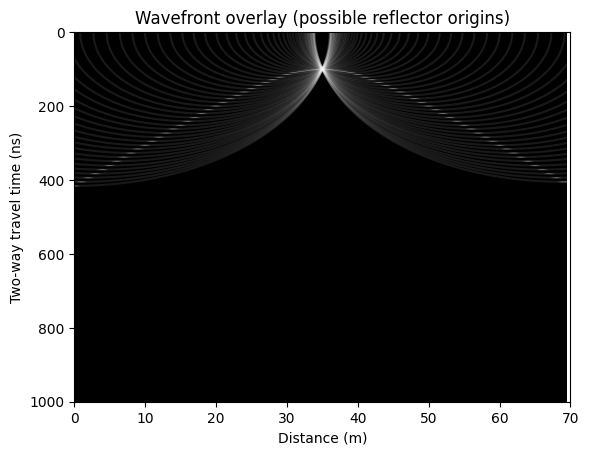

In [4]:
def plot_wavefront_overlay(data, dt, dx, v, threshold=0.1, max_traces=None):

    nt, nx = data.shape
    t = np.arange(nt) * dt
    x = np.arange(nx) * dx

    fig, ax = plt.subplots()
    ax.imshow(data, aspect='auto', cmap='gray')
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Two-way travel time (ns)')
    ax.set_title('Wavefront overlay (possible reflector origins)')

    # restrict to some traces for visual clarity
    trace_indices = range(0, nx, max(1, nx // (max_traces or nx)))

    for i in trace_indices:
        trace = data[:, i]

        # get indices where amplitude exceeds threshold
        strong_idx = np.where(trace > threshold)[0]

        for j in strong_idx:
            t_j = t[j]
            r = v * t_j / 2  # one-way path
            # generate circle coordinates
            theta = np.linspace(np.pi/2, 3*np.pi/2, 100)
            x_wave = x[i] + r * np.sin(theta)
            z_wave = -r * np.cos(theta)
            
            ax.plot(x_wave, z_wave * 1e9 / (v / 2), c="white", alpha=0.1)
        ax.set_xlim(0, len(x))
        ax.set_ylim(len(t), 0)
    plt.show()

plot_wavefront_overlay(data, dt, dx, 3e8/np.sqrt(3), threshold=0.1, max_traces=None)

# Stack and plot the pulse for each signal

In [5]:
stackh = lambda array : np.sum(array, axis=1)/array.shape[1]

def NMO_correction(data, eps_r, t_0, x_0):
    v = (c/np.sqrt(eps_r))/1e9         # [ns]
    
    NMO_corrected_data = np.zeros_like(data)
    
    nt, nx = data.shape
    for x in range(nx):
        x_offset = np.abs(x - x_0)
        t_correction = np.sqrt(t_0**2+(2*x_offset/v)**2)-t_0
        trace_original = data[:, x]
        
        t_range = np.arange(0, nt, 1) # 
        
        shifted = np.interp(t_range, t_range - t_correction, trace_original, left=0, right=0)
        NMO_corrected_data[:, x] = shifted
        
    return NMO_corrected_data

Text(0.5, 1.0, 'c-10%')

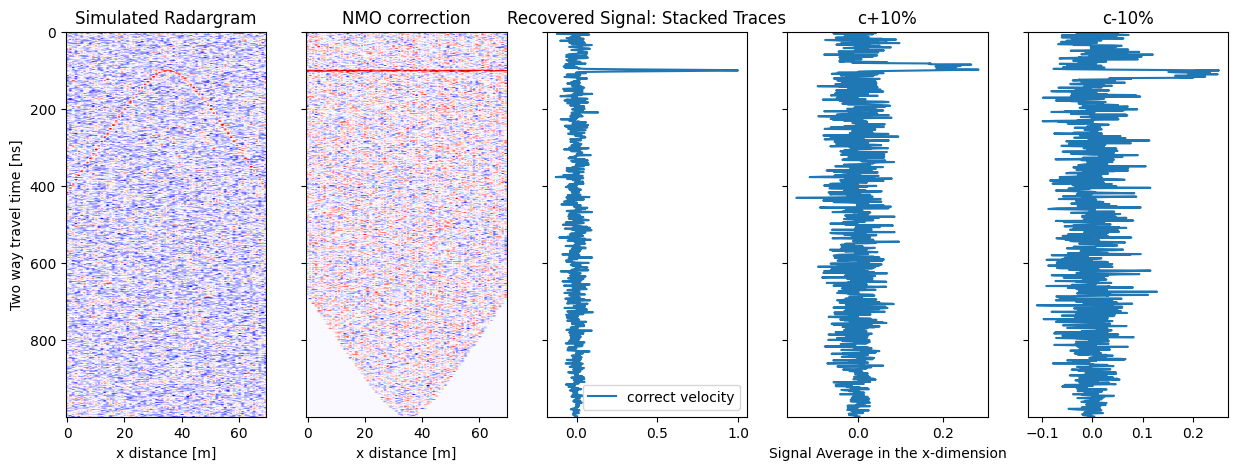

In [7]:
t_0, x_0 = 100, 35 # The zero-offset time [ns] and 'CMP' [m] (the position of the reflector which we assume we know -- though can be estimated pretty easily)
eps_r = 3.0
wavetype = 'gaussian'
SNR = 0.02

data, x_positions, t_samples = gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
corrected = NMO_correction(data, eps_r, t_0, x_0) 


fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
plt.gca()
axs[0].imshow(data, aspect='auto', cmap='seismic')
im = axs[1].imshow(corrected, aspect='auto', cmap='seismic')
stack = stackh(corrected)
axs[2].plot(stack, range(0,len(stack)), label='correct velocity')


eps_r = 3.3
stack = stackh(NMO_correction(data, eps_r, t_0, x_0))
axs[3].plot(stack, range(0,len(stack)), label='velocity+10%')


eps_r = 2.7
stack = stackh(NMO_correction(data, eps_r, t_0, x_0))
axs[4].plot(stack, range(0,len(stack)), label='velocity-10%')


'''Desktop/ResolutionGuyotProj/Code/Point_Counting/Matrix_indev/Kmask/RoPeR_prcs/GPR_modeling
Making the plot pretty
'''
axs[0].set_title('Simulated Radargram'); axs[0].set_ylabel('Two way travel time [ns]'); axs[0].set_xlabel('x distance [m]')
axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]')
axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
axs[4].set_title('c-10%')

# Making a pretty figure

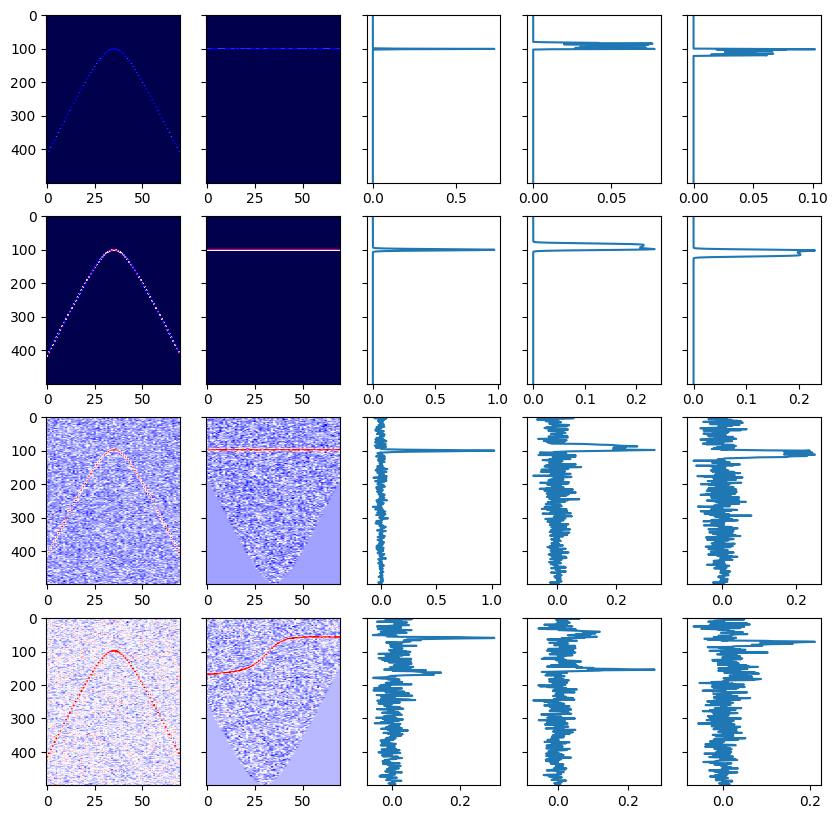

In [11]:
correct_t_0 = 100; correct_x_0 = 35; correct_eps_r = 3.0
params = {0:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'spike', 'SNR':math.inf}, 
          1:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':math.inf}, 
          2:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':0.08}, 
          3:{'t_0':correct_t_0+20, 'x_0':correct_x_0-5, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':0.08}}

rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 5e-7)  # grid (x,z)
reflectors = [(35, 50e-9)]

fig, axs = plt.subplots(4, 5, figsize=(10,10), sharey=True)
if isinstance(axs, np.ndarray):
    grid = axs.shape
    
for i in range(grid[0]):
    # Simulate a survey
    t_0, x_0 = params[i]['t_0'], params[i]['x_0']
    eps_r = params[i]['eps_r']
    wavetype = params[i]['wavetype']
    SNR = params[i]['SNR']

    data, x_positions, t_samples = gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
    corrected = NMO_correction(data, eps_r, t_0, x_0) 

    axs[i][0].imshow(data, aspect='auto', cmap='seismic')
    im = axs[i][1].imshow(corrected, aspect='auto', cmap='seismic')
    stack = stackh(corrected)
    axs[i][2].plot(stack, range(0,len(stack)), label='correct velocity')


    eps_r = 3.3
    stack = stackh(NMO_correction(data, eps_r, t_0, x_0))
    axs[i][3].plot(stack, range(0,len(stack)), label='velocity+10%')


    eps_r = 2.7
    stack = stackh(NMO_correction(data, eps_r, t_0, x_0))
    axs[i][4].plot(stack, range(0,len(stack)), label='velocity-10%')

    # '''Desktop/ResolutionGuyotProj/Code/Point_Counting/Matrix_indev/Kmask/RoPeR_prcs/GPR_modeling
    # Making the plot pretty
    # '''
    # axs[0].set_title('Simulated Radargram'); axs[0].set_ylabel('Two way travel time [ns]'); axs[0].set_xlabel('x distance [m]')
    # axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]'), ; fig.colorbar(im, ax=axs[1], orientation='vertical')
    # axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
    # axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
    # axs[4].set_title('c-10%')